In [27]:
#here is an exapmple of a filter for the web that i have been using for for time
#this is the basic algorithm for a single pass filter

   $$y[i] = ß * x[i] + (1-ß) * y[i-1]$$
   
Where y is an array of smooth data and x is raw data
   
which can also be expressed as: $$y[i] = Y[i-1] - (ß*(Y[i-1]-X[i]))$$

#### Here is an implementation in python

In [28]:
class simple_lowPass:
    
    def filt(self, signal, Beta):
        
        output = np.zeros(len(signal))
        #o[0] = 0 - (Beta * (0 - signal[0]))
        for i in range (1, len(signal)):
            output[i] = output[i-1] - (Beta * (output[i-1] - signal[i]))
            #signal[i] = signal[i-1] - (Beta * (signal[i-1] - signal[i]))
            
        return output
    

#### Lets apply a filter to white to noise and see what happens

In [29]:
import numpy as np
import cmath

class waveGen:
	
	def __init__(self, freq, BufferSize, waveType, vol):
		
		self.sampleRate = 48000
		self.bufferSize = BufferSize
		self.buffer = np.empty(BufferSize, dtype=np.complex)
		self.frequency = freq
		self.omega = 0
		self.updateOmega()
		self.last = complex(1,0)
		self.type = waveType
		self.volume = vol

	def sineGen(self):

		#start = timer() #reduce function!!! functools
		for i in range(0, self.bufferSize):
			self.buffer[i] = self.last
			self.last=self.last*self.omega

		return self.volume * np.imag(self.buffer).astype(np.float32)

	def squareGen(self):
		#start = timer()
		for i in range(0, self.bufferSize):
			self.buffer[i] = np.sign(self.last)
			self.last=self.last*self.omega

		return np.real(self.volume * self.buffer).astype(np.float32)

	def updateOmega(self):
		self.omega = cmath.exp(1j*(2*cmath.pi * self.frequency / self.sampleRate))

	def updateFreq(self, val):
		self.frequency = val
		self.updateOmega()

	def nextFrame(self):
		if self.type == "sine":
			return self.sineGen()
		elif self.type == "square":
			return self.squareGen()




In [30]:
#### will ver very ineficiantly crate white noise by layering sine at all freqs
####this will be slow but very predictable

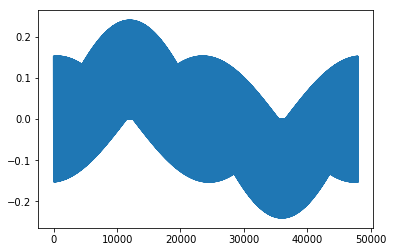

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

length = 48000
noise = np.zeros(length)
wave = waveGen(1, length, 'sine', .01)

for i in range(1, 24000, 1000):
    wave.updateFreq(i)
    noise += wave.nextFrame()


plt.plot(noise)
plt.show()

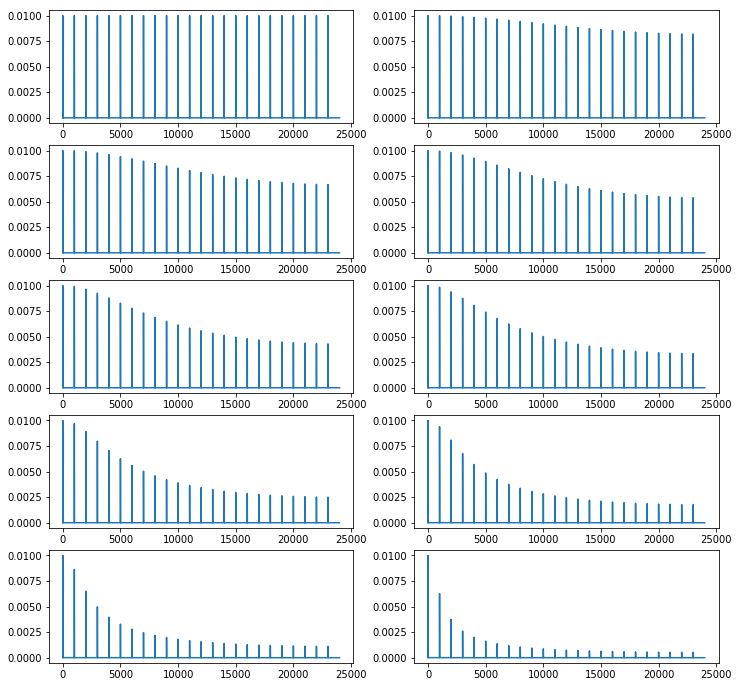

In [32]:
Filter = simple_lowPass()
fft_data = []
##fft_data += np.fft.fft(noise)
for i in range(10):
    fft_data.append(np.fft.fft(Filter.filt(noise, 1 - i/10)))

#plotting stuff
fig = plt.figure(figsize=(12, 12))
ax = []
T = 1.0 / length
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)


for i in range(10):
    ax.append(fig.add_subplot(5, 2, i+1))
    ax[i].plot(xf, 2.0/length * np.abs(fft_data[i][:length//2]))


plt.show()

#### Alternativly this can be modified to encorporate multiple passes.
#### The furmular for which can be simplified as

$$y[i] = y[i-1] - (ß ** r) * y[i-1] + (ß ** r) * x[i]$$

where r represents the iterations of passes

In [33]:
class exponential_lowPass:
    
    def filt(self, signal, Beta, reps):
        
        output = np.zeros(len(signal))
        for i in range (1, len(signal)):
            output[i] = output[i-1] - (Beta ** reps) * output[i-1] + (Beta ** reps) * signal[i]
            
        return output

#### Below is the responce

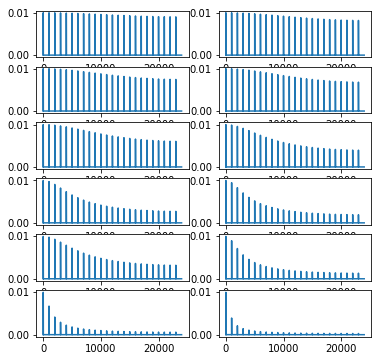

In [34]:
Filter = exponential_lowPass()
fft_data = []
##fft_data += np.fft.fft(noise)
for i in range(3):
    for j in range(4):
        fft_data.append(np.fft.fft(Filter.filt(noise, .9 - i/3, (j+1)/2)))

#plotting stuff
fig = plt.figure(figsize=(6, 6))
ax = []
T = 1.0 / length
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)


for i in range(12):
    ax.append(fig.add_subplot(6, 2, i+1))
    ax[i].plot(xf, 2.0/length * np.abs(fft_data[i][:length//2]))


plt.show()

# lets look at this in the time domain

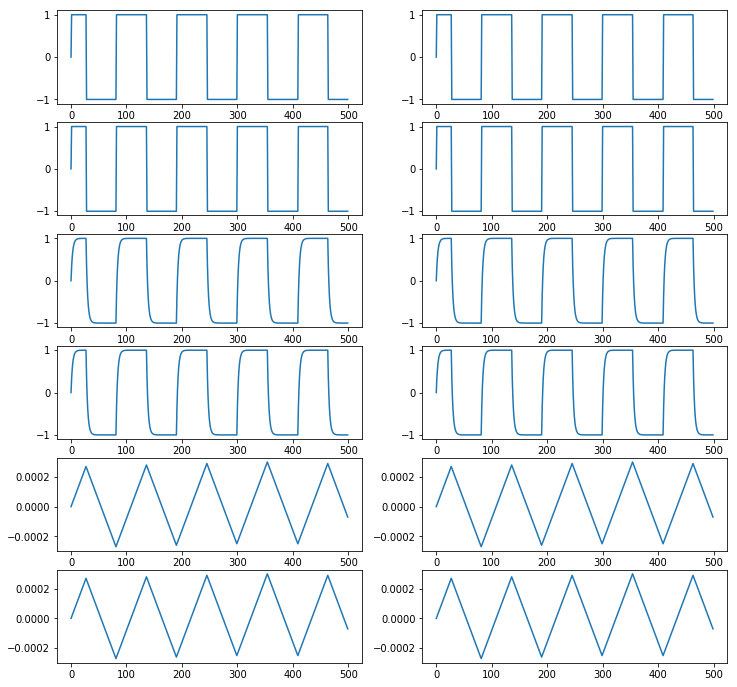

In [52]:
SquareGen = waveGen(440, 48000, 'square', 1)
square = SquareGen.nextFrame()

data = []
cuttoffVals = [.2, .1, .00001]
betaVals = [0, .5, 1, 300]
for i in range(3):
    for j in range(4):
        data.append(Filter.filt(square, cuttoffVals[i], betaVals[i]))

fig = plt.figure(figsize=(12, 12))
ax = []
for i in range(12):
    ax.append(fig.add_subplot(6, 2, i+1))
    ax[i].plot(data[i][:500])


plt.show()


### This is not a very precise method, though it can work as a simple low pass filter it will not surfice as an anti-aliasing filter. nor does it have a q value for musical use